<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/07%20-%20Reaction%20Prediction/template_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7: reaction prediction with Molecular Transformer

We have talked about different reaction prediction methods. Template-based approaches use reaction templates to select the most likely reaction outcome. However, these models are limited by the dataset (the model can just learn reaction classes, and is not able to get deeper features), quality and quantity of the templates (you can only predict reactions that are included in your templates, and the model will be heavily dependent on the quality of the atom mapping), and they cannot predict selectivity.

On the other hand, template-free models can overcome many of these limitations. Today, we will use a language model, the Molecular Transformer, to do chemical reaction prediction. You can check the original paper [here](https://pubs.acs.org/doi/full/10.1021/acscentsci.9b00576).

This model is based on the Transformer architecture, which is behind some of the most remarkable AI models of the last years (eg. [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) or [ChatGPT](https://chat.openai.com/)). Basically, we will treat reaction prediction as a machine translation model, where the model will learn the "grammar of the reactions". Some of the main advantages of the model are

![](https://pubs.acs.org/cms/10.1021/acscentsci.9b00576/asset/images/medium/oc9b00576_0009.gif)
</br><left>Figure 1: SMILES-to-SMILES translation with the Molecular Transformer

# 0. Relevant packages

### OpenNMT
OpenNMT is an open-source library for translation tasks. We will use it to create and train our model as it is a flexible and easy to use framework. You can check the documentation [here](https://opennmt.net/OpenNMT-py/index.html).

We will also use rdkit and other common auxiliary libraries.

In [1]:
# check if you have a notebook with a GPU
import torch
torch.cuda.is_available()
# If False, Go to Menu > Runtime > Change runtime. Hardware accelerator -> GPU

True

In [2]:
! pip install "numpy<2.0.0"
! pip install torch==2.1
! pip install rdkit
! pip install OpenNMT-py==2.2.0
! wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/07%20-%20Reaction%20Prediction/utils.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.8/216.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 4.7 MB/s eta 0:00:00
--2025-04-02 13:10:07--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/07%20-%20Reaction%20Prediction/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4725 (4.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.61K  --.-KB/s    in 0s      

2025-04-02 13:10:08 (61.6 MB/s) - ‘utils.py’ saved [4

In [1]:
import re
import os
import gdown
import random

import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()
from rdkit import Chem

# to display molecules
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

# disable RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from utils import download_data, canonicalize_smiles, evaluate

# Download data

Firstly, we will download the data for training. We will use [USPTO](https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873), a widely used dataset containing reaction SMILES extracted from the US list of patents from 1976 to 2016.

In [2]:
train_df, val_df, test_df = download_data()

Downloading...
From: https://drive.google.com/uc?id=1RysNBvB2rsMP0Ap9XXi02XiiZkEXCrA8
To: /content/USPTO_480k/src-train.txt
100%|██████████| 57.4M/57.4M [00:00<00:00, 203MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CxxcVqtmOmHE2nhmqPFA6bilavzpcIlb
To: /content/USPTO_480k/tgt-train.txt
100%|██████████| 33.8M/33.8M [00:00<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FFN1nz2yB4VwrpWaBuiBDzFzdX3ONBsy
To: /content/USPTO_480k/src-val.txt
100%|██████████| 4.21M/4.21M [00:00<00:00, 239MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pYCjWkYvgp1ZQ78EKQBArOvt_2P1KnmI
To: /content/USPTO_480k/tgt-val.txt
100%|██████████| 2.47M/2.47M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=10t6pHj9yR8Tp3kDvG0KMHl7Bt_TUbQ8W
To: /content/USPTO_480k/src-test.txt
100%|██████████| 5.64M/5.64M [00:00<00:00, 201MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FeGuiGuz0chVBRgePMu0pGJA4FVReA-b
To: /content/USPTO_480k/tgt-test.txt
10

The training set contains 409035 reactions.
The testing set contains 40000 reactions.
The validation set contains 30000 reactions.


After running this cell you should get these sets (check the USPTO_480 folder in your Colab directory):

    - Train: we will use these reaction SMILES to train the model
    - Validation: used for checking the learning progress during training and hyperparameter tuning
    - Test: we will use these data only once we get the final model to test its performance

Each set contains two `.txt` files, one containing the precursors (reactants, src) and another containing the targets (products, tgt). Remember that our task can be seen as a translation between two sequences, reactants and products SMILES in this case.

# Tokenization <a class="anchor" id="third-bullet"></a>

We already mentioned tokenization in the previous tutorial when training the LSTM. To be able to train a language model, we need to split the strings into tokens.

We take the regex pattern introduced in the [Molecular Transformer](https://pubs.acs.org/doi/abs/10.1021/acscentsci.9b00576) paper.

In [3]:
SMI_REGEX_PATTERN =  r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def smiles_tokenizer(smiles):
    smiles_regex = re.compile(SMI_REGEX_PATTERN)
    tokens = [token for token in smiles_regex.findall(smiles)]
    return ' '.join(tokens)


print('Tokenizing training set')
train_df['tokenized_precursors'] = train_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
train_df['tokenized_products'] = train_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing validation set')
val_df['tokenized_precursors'] = val_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
val_df['tokenized_products'] = val_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing test set')
test_df['tokenized_precursors'] = test_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
test_df['tokenized_products'] = test_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))

Tokenizing training set


  0%|          | 0/409035 [00:00<?, ?it/s]

  0%|          | 0/409035 [00:00<?, ?it/s]

Tokenizing validation set


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Tokenizing test set


  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

## Save the preprocessed data set

Don't forget to shuffle the training set before saving it. At least earlier versions of OpenNMT-py would not shuffle it during preprocessing. After that, we save the tokenized files, which are now ready to use for training.

In [4]:
shuffled_train_df = train_df.sample(frac=1., random_state=42)
data_path = 'USPTO_480k_preprocessed'

os.makedirs(data_path, exist_ok=True)
with open(os.path.join(data_path, 'precursors-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_products.values))

with open(os.path.join(data_path, 'precursors-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_products.values))

with open(os.path.join(data_path, 'precursors-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_products.values))

# Building the vocab <a class="anchor" id="fourth-bullet"></a>

The first step for the [OpenNMT-py pipeline](https://opennmt.net/OpenNMT-py/quickstart.html) is to build the vocabulary.

![](https://camo.githubusercontent.com/69fb11841ce1abd51a3fd7f3ed4b424857029ce123521cc301eb48a1e22bee2f/687474703a2f2f6f70656e6e6d742e6769746875622e696f2f73696d706c652d6174746e2e706e67)
</br><left>Figure 2: In contrast to a neural machine translation model for human language, we will use an atom-wise vocabulary.


Please note:
- Typical sequence pairs in machine translation are much shorter than the ones you encounter in chemical reaction prediction. Hence, set a `src_seq_length` and `tgt_seq_length` that is much higher than the maximum you would expect to include all reactions (in this case we set a value of 1000).
- With `n_sample` set to `-1` we include the whole dataset.

The paths to the training and validation datasets are defined in the `run_config.yaml`:

```yaml
# Here you can check the documentation to know better how this file works.
# https://opennmt.net/OpenNMT-py/quickstart.html
# Examples in https://github.com/OpenNMT/OpenNMT-py/tree/master/config

## Where the samples will be written
save_data: example_run
## Where the vocab(s) will be written
src_vocab: example_run/uspto.vocab.src
tgt_vocab: example_run/uspto.vocab.src
# Prevent overwriting existing files in the folder
overwrite: true
share_vocab: true

# Corpus opts:
data:
    corpus-1:
        path_src: USPTO_480k_preprocessed/precursors-train.txt
        path_tgt: USPTO_480k_preprocessed/products-train.txt
    valid:
        path_src: USPTO_480k_preprocessed/precursors-val.txt
        path_tgt: USPTO_480k_preprocessed/products-val.txt
```

As the source (precusors) and the target (products) are represented as SMILES and consist of the same tokens, we share the vocabulary between source and target (`share_vocab: true`).

In [5]:
config_url = 'https://raw.githubusercontent.com/schwallergroup/dmds_language_models_for_reactions/main/example_run/run_config.yaml'
config_folder = 'example_run'
config_name = 'run_config.yaml'

os.makedirs(config_folder, exist_ok=True)
target_path = os.path.join(config_folder, config_name)
if not os.path.exists(target_path):
    gdown.download(config_url, target_path, quiet=False)
else:
    print(f"{target_path} already exists")

Downloading...
From: https://raw.githubusercontent.com/schwallergroup/dmds_language_models_for_reactions/main/example_run/run_config.yaml
To: /content/example_run/run_config.yaml
961B [00:00, 1.66MB/s]                   


Now we can run this command to build our vocabulary file.

In [6]:
! onmt_build_vocab -config example_run/run_config.yaml \
    -src_seq_length 1000 -tgt_seq_length 1000 \
    -src_vocab_size 1000 -tgt_vocab_size 1000 \
    -n_sample -1

Corpus corpus-1's weight should be given. We default it to 1 for you.
[2025-04-02 13:11:45,764 INFO] Counter vocab from -1 samples.
[2025-04-02 13:11:45,764 INFO] n_sample=-1: Build vocab on full datasets.
[2025-04-02 13:11:45,780 INFO] corpus-1's transforms: TransformPipe()
[2025-04-02 13:11:52,177 INFO] Counters src:281
[2025-04-02 13:11:52,177 INFO] Counters tgt:128
[2025-04-02 13:11:52,177 INFO] Counters after share:292


You can check how the `uspto.vocab.src` in the `example_run` folder to see how the vocabulary looks like.

# Training the Molecular Transformer <a class="anchor" id="fifth-bullet"></a>

If you look at the `run_config.yaml`, you will see that we have defined some of the training parameters (but not yet the hyperparameters of the model).

```yaml
# Train on a single GPU
world_size: 1
gpu_ranks: [0]

# Where to save the checkpoints
save_model: example_run/model
save_checkpoint_steps: 5000
keep_checkpoint: 3
train_steps: 400000
valid_steps: 10000
report_every: 100

tensorboard: true
tensorboard_log_dir: log_dir
```

The Transformer architecture was published in the [Attention is all you need](https://proceedings.neurips.cc/paper/7181-attention-is-all-you-need) paper by Vaswani et al. (NeurIPS, 2017). The model sizes (65 to 212M parameters) in that paper were larger than what we use for reaction prediction (20M parameters).

![](https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter01_self-attention.png)
</br><left>Figure 3: Transformer model (source: https://github.com/nlp-with-transformers). </left>

Illustrated transformer blogposts:
- https://nlp.seas.harvard.edu/2018/04/03/attention.html
- https://jalammar.github.io/illustrated-transformer/

The cell below contains the command used to train the model. Here you can set all your hyperparameters. In this case, we will use the values that were published in this [paper](https://www.nature.com/articles/s41467-020-18671-7), where the Molecular Transformer was trained to predict carbohydrate reactions.

In [ ]:
# hyperparameters from https://github.com/rxn4chemistry/OpenNMT-py/tree/carbohydrate_transformer
!onmt_train -config example_run/run_config.yaml \
        -seed 42 -gpu_ranks 0  \
        -param_init 0 \
        -param_init_glorot -max_generator_batches 32 \
        -batch_type tokens -batch_size 6144\
        -normalization tokens -max_grad_norm 0  -accum_count 4 \
        -optim adam -adam_beta1 0.9 -adam_beta2 0.998 -decay_method noam  \
        -warmup_steps 8000 -learning_rate 2 -label_smoothing 0.0 \
        -layers 4 -rnn_size  384 -word_vec_size 384 \
        -encoder_type transformer -decoder_type transformer \
        -dropout 0.1 -position_encoding -share_embeddings  \
        -global_attention general -global_attention_function softmax \
        -self_attn_type scaled-dot -heads 8 -transformer_ff 2048 \
        -tensorboard True -tensorboard_log_dir log_dir

The training can take more than `24 hours` on a single GPU! Hence, stop the previous cell, we will directly download the trained model :)

In [7]:
trained_model_url = 'https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy'
model_folder = 'models'
model_name = 'USPTO480k_model_step_400000.pt'

os.makedirs(model_folder, exist_ok=True)
target_path = os.path.join(model_folder, model_name)
if not os.path.exists(target_path):
    gdown.download(trained_model_url, target_path, quiet=False)
else:
    print(f"{target_path} already exists")

Downloading...
From (original): https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy
From (redirected): https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy&confirm=t&uuid=be5067e5-894c-4656-aeea-68579be9c0d3
To: /content/models/USPTO480k_model_step_400000.pt
100%|██████████| 95.2M/95.2M [00:01<00:00, 60.9MB/s]


# Evaluating the model

We'll use a pre-made script for this, don't worry about it now. Basically we want to check what percentage of the predictions are correct (we compute the accuracy of the model). *This cell takes around 20 minutes to execute, as we are using the model to predict nearly 40k reactions*

In [ ]:
!onmt_translate -model models/USPTO480k_model_step_400000.pt -gpu 0 \
    --src USPTO_480k_preprocessed/precursors-val.txt \
    --tgt USPTO_480k_preprocessed/products-val.txt \
    --output models/USPTO480k_model_step_400000_val_predictions.txt \
    --n_best 5 --beam_size 10 --max_length 300 --batch_size 64

For each reaction, we obtain 5 predictions that can be used to compute the accuracy. The `top-n` accuracy is the accuracy that includes the best n predictions (for example, top-3 accuracy will consider one prediction as true if the true product matches any of the best 3 predictions). Now run this to compute the accuracy of the model. What do these numbers tell you?

In [ ]:
evaluate(n_best=5)

## Exercise: Test the limits of the Molecular Transformer!

Now it's your turn! Try to make some predictions using the Molecular Transformer and check its limitations. You can try to explore reactions with challenging stereochemistry or regioselectivity, and see if the model is able to correctly get them.

The SMILES of the predicted product is: C#CCC(O)C1=C(F)C(F)=C(F)C(F)=C1F


Visualization of the reaction:

Precursors:


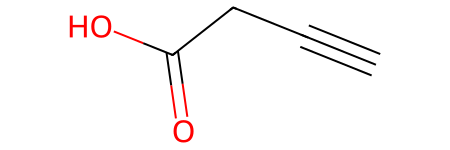

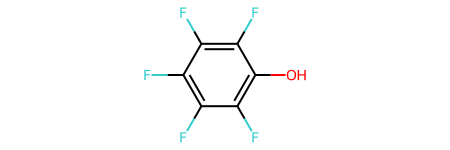

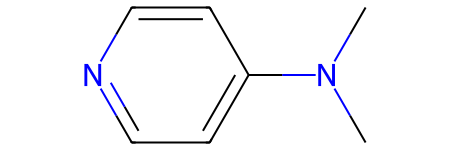

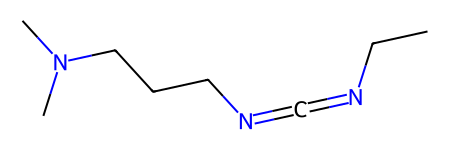

Product:


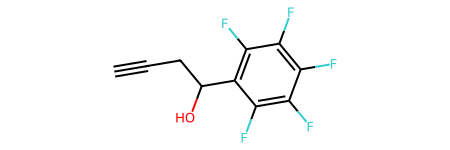

In [12]:
# It's an example

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display


def predict_reaction(precursors):
    """ predict product of one reaction from its precursors SMILES list
    """

    smi_pres = '.'.join(precursors)
    smi_pres = smiles_tokenizer(smi_pres)

    with open('precursors-try.txt', 'w') as f:
        f.write(f'{smi_pres}\n')

    os.system("rm preds.txt")
    os.system("onmt_translate -model models/USPTO480k_model_step_400000.pt -gpu 0 \
               --src precursors-try.txt --output preds.txt \
               --n_best 2 --beam_size 5 --max_length 300 --batch_size 64")

    with open('preds.txt', 'r') as f:
        pred_smi = f.readline().strip()
        pred_smi = pred_smi.replace(" ", "")

    # print result
    print(f"The SMILES of the predicted product is: {pred_smi}")
    # Use RDKit to visualize the reactants and product
    # precursors
    print("\n\nVisualization of the reaction:\n")
    print("Precursors:")
    precursors_mols = [Chem.MolFromSmiles(smi) for smi in precursors]
    [display(mol) for mol in precursors_mols]
    print("Product:")
    product_mol = Chem.MolFromSmiles(pred_smi)
    display(product_mol)

    return pred_smi

# Write the SMILES of all precursors for a reaction you want to predict into a list
precursors_smis = ["OC(CC#C)=O", "OC1=C(F)C(F)=C(F)C(F)=C1F", "CN(C)C2=CC=NC=C2","CN(C)CCCN=C=NCC"]

pred_smi = predict_reaction(precursors_smis)

In [ ]:
"COC(=O)c1cc2c3cccc(Cl)c3n(C)c2s1",
    "[K+].[OH-]"